In [270]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import sys, os
sys.path.append('C:\\Users\Quentin\\Documents\\ALMA_CHILI\\gaia-shock\\src')

## directory
rootdir = r'C:\Users\Quentin\Documents\ALMA_CHILI'
wdir    = r'%s\products'%(rootdir)
#notedir = r'%s\gaia-shock\notebooks_Quentin'%(rootdir)

os.chdir(wdir)  # to change the current directory
import gaia_utils_quentin as gu

with open('ilabel_dbscan', 'rb') as fichier:
    my_depickler = pickle.Unpickler(fichier)
    file_result = my_depickler.load()

In [2]:
for i in file_result : 
    print(i,file_result[i]['eps_min_samples'],len(file_result[i]['ilabel']))

NGC2516_0.01 (0.56, 30) 416
NGC2516_0.02 (0.56, 30) 1003
NGC2516_0.03 (0.56, 30) 1322
NGC2516_0.2 (0.4, 30) 1970
NGC2682_0.2 (0.73, 30) 1107
NGC2632_0.2 (0.35, 30) 767
NGC752_0.2 (0.71, 30) 275
NGC2632_0.03 (0.49, 30) 734
NGC1647_0.2 (0.5, 30) 341


In [115]:
voname_list = ["NGC2682-4.0deg-0.2err.vot", "NGC2516-3.5deg-0.2err.vot", "NGC2516-6.0deg-0.2err.vot","NGC6811-1.0deg-0.2err.vot"]
#tab_source = []
#tab_ilabel = []
for voname in [voname_list[0]] :
    source = gu.source()
    source.read_votable(voname)
    source.convert_filter_data()
    source.convert_to_cartesian()
    tab_source.append(source)
    
    ilabel = file_result[source.name]['ilabel']
    tab_ilabel.append(ilabel)

## NGC2682-4.0deg-0.2err.vot read...
## Total stars: 46444
## Density star per pc^3: 0.00413

## Conversion done...
## Stars selected: 45802


mean Dist: 873.3,    1255 stars


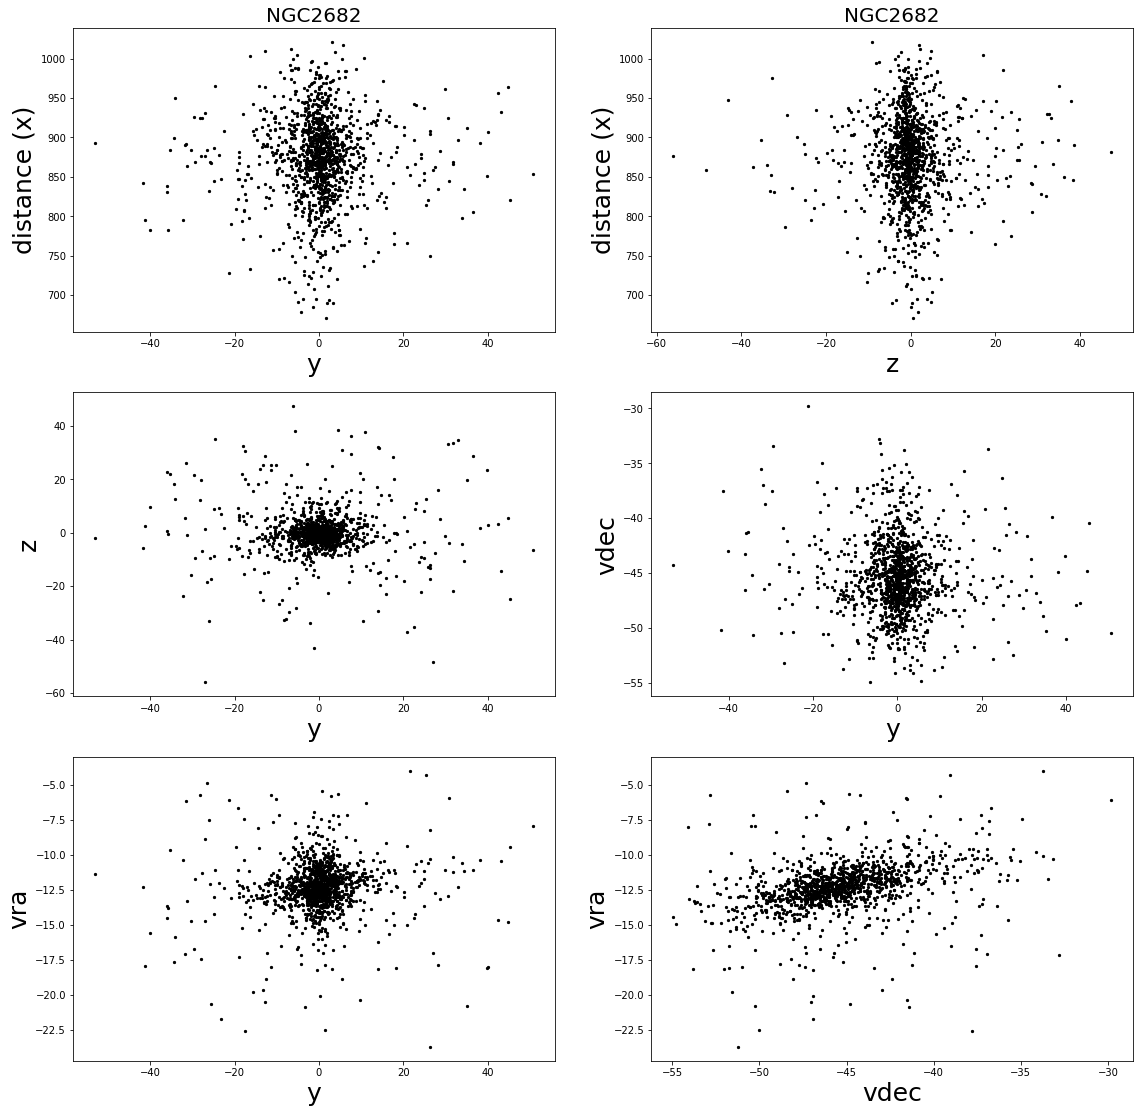

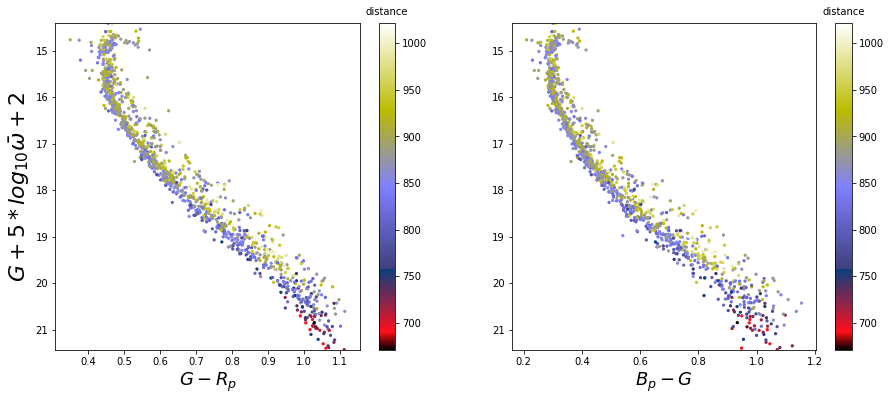

In [137]:
tab_name =  ["NGC2682","NGC2516","NGC2516_2","NGC2516_3","NGC2516_4","NGC6811"]
name = tab_name[0]

print("mean Dist: %5.1f,    %d stars"%(np.mean(file_result[name]['data_cart'][:,0]),len(file_result[name]['data_cart'])))
#print("mean vdec: %5.1f, std : %.3f"%(np.mean(file_result[name]['data_cart'][:,3])))
#print("mean vra: %5.1f, std : %.3f"%(np.mean(file_result[name]['data_cart'][:,4])))
gu.plot_information_cluster(file_result[name]['data_cart'], size=5, cartesian=True, HRD=True, title=name)


mean Dist: 413.8,    2812 stars


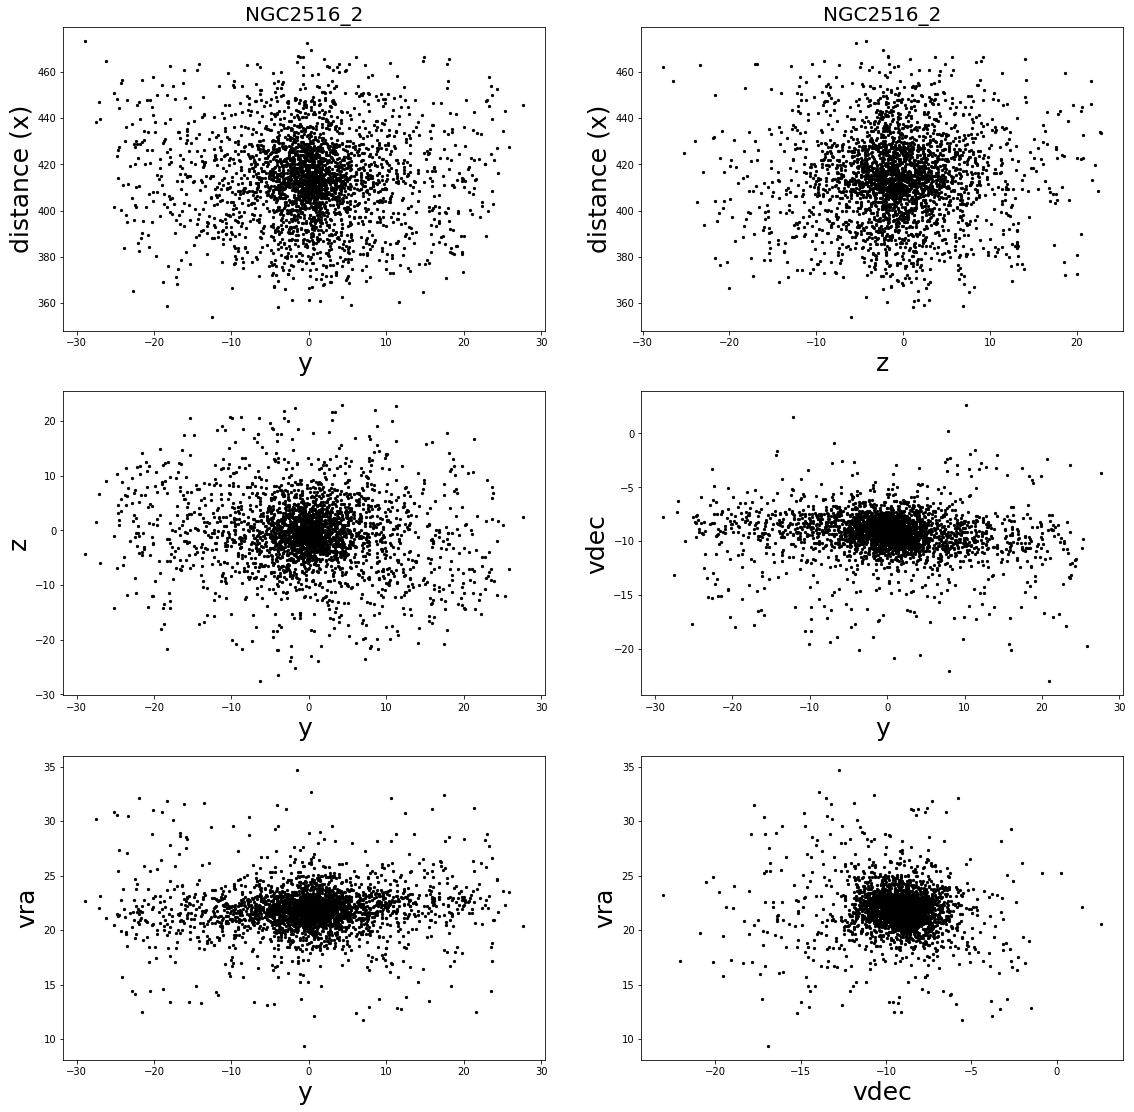

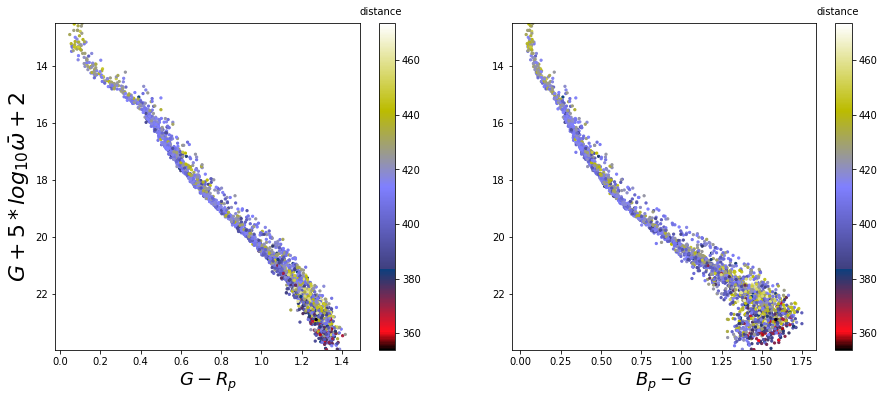

In [51]:
tab_name =  ["NGC2682","NGC2516","NGC2516_2","NGC6811"]
name = tab_name[2]

print("mean Dist: %5.1f,    %d stars"%(np.mean(file_result[name]['data_cart'][:,0]),len(file_result[name]['data_cart'])))
#print("mean vdec: %5.1f, std : %.3f"%(np.mean(file_result[name]['data_cart'][:,3])))
#print("mean vra: %5.1f, std : %.3f"%(np.mean(file_result[name]['data_cart'][:,4])))
gu.plot_information_cluster(file_result[name]['data_cart'], size=5, cartesian=True, HRD=True, title=name)


mean Dist: 873.3,    1255 stars


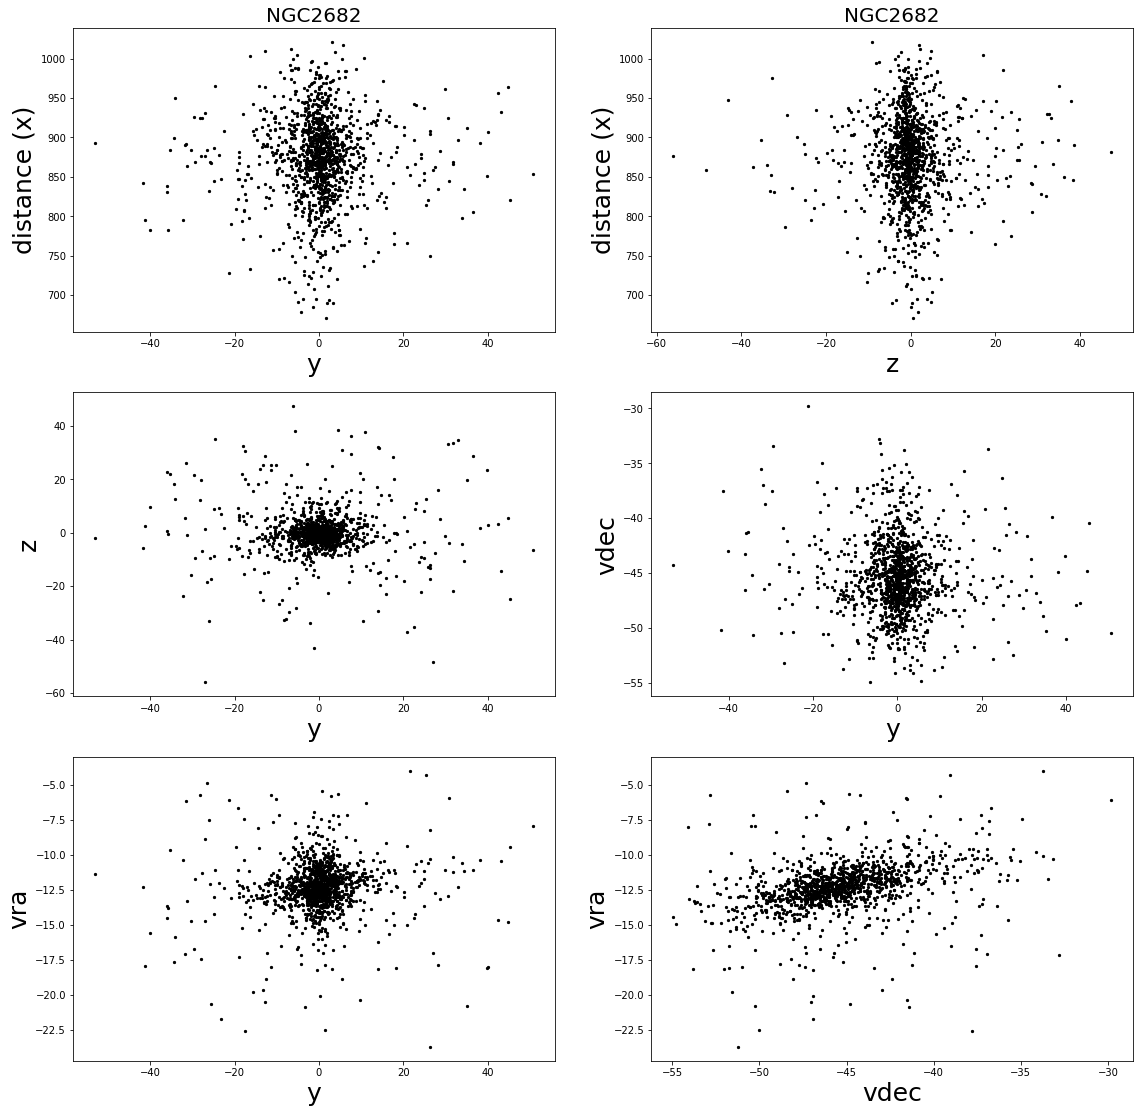

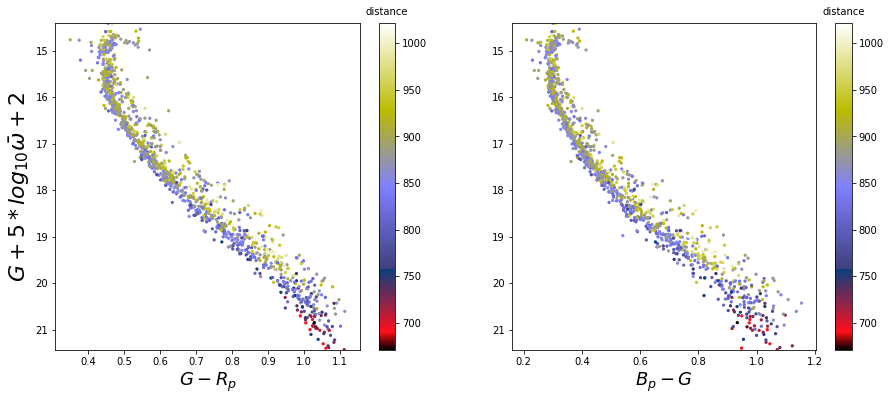

In [12]:
tab_name =  ["NGC2682","NGC2516","NGC2516_2","NGC6811","NGC1647"]
name = tab_name[0]

print("mean Dist: %5.1f,    %d stars"%(np.mean(file_result[name]['data_cart'][:,0]),len(file_result[name]['data_cart'])))
#print("mean vdec: %5.1f, std : %.3f"%(np.mean(file_result[name]['data_cart'][:,3])))
#print("mean vra: %5.1f, std : %.3f"%(np.mean(file_result[name]['data_cart'][:,4])))
gu.plot_information_cluster(file_result[name]['data_cart'], size=5, cartesian=True, HRD=True, title=name)


In [15]:
#tab_source[0].plot_information(0.01,True, HRD=True, ilabel=tab_ilabel[0])
#tab_source[0].plot_3D(0.01,True,(0,6,5),ilabel=tab_ilabel[0])
#gu.HRD_cluster(source.df,size=0.3)
#gu.HRD_cluster(source.df[ilabel,:],size=0.8)

In [16]:
def get_maxmin_index(mag, percentage = 10) :
    "Select max and min 'percentage'% index of mag array"
    list_mag = []
    for i in range(len(mag)) :
        list_mag.append([mag[i],i])
    tab_index = np.array(sorted(list_mag)).astype(int)[:,1]

    # Select index magnitude for min and max
    imin_mag = tab_index[:int(percentage/100*len(mag))]
    imax_mag = tab_index[-int(percentage/100*len(mag)):]
    
    return imin_mag, imax_mag

In [127]:
tab_name =  ["NGC2682","NGC2516","NGC2516_2","NGC6811","NGC1647"]
name = tab_name[4]
data = file_result[name]['data_cart']
print(len(data))

imin_mag, imax_mag = get_maxmin_index(data[:,5], percentage = 50)

625


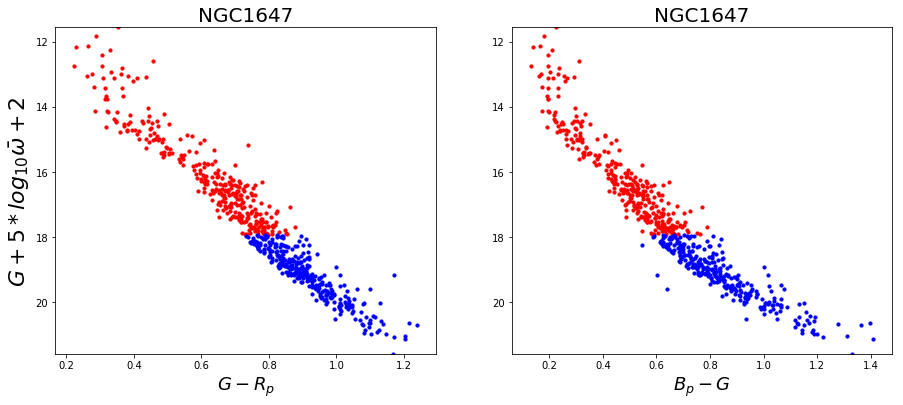

In [128]:
plt.figure(figsize=(15,6))
G_max = np.max(data[:,5])
G_min = np.min(data[:,5])
for i in (6,7) :
    plt.subplot(1,2,i-5)
    plt.ylim(G_max, G_min)
    plt.title(name, fontsize=20)
    plt.scatter(data[:,i], data[:,5], s=1, c='k')
    plt.scatter(data[imin_mag,i], data[imin_mag,5], s=10, c='r')
    plt.scatter(data[imax_mag,i], data[imax_mag,5], s=10, c='b')
    plt.xlabel(gu.data_name[i], fontsize=18)
    if i == 6 : plt.ylabel(gu.data_name[5], fontsize=22)
plt.show()

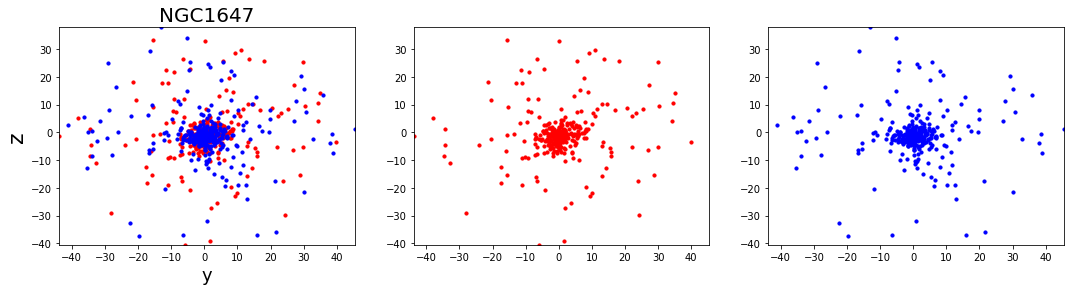

In [129]:
plt.figure(figsize=(18,4))
plt.subplot(131)
plt.title(name, fontsize=20)
plt.scatter(data[:,1], data[:,2], s=1, c='k')
plt.scatter(data[imin_mag,1], data[imin_mag,2], s=10, c='r')
plt.scatter(data[imax_mag,1], data[imax_mag,2], s=10, c='b')
plt.xlabel(gu.data_name_cart[1], fontsize=18)
plt.ylabel(gu.data_name_cart[2], fontsize=22)
plt.xlim(min(data[:,1]),max(data[:,1]))
plt.ylim(min(data[:,2]),max(data[:,2]))
plt.subplot(132)
plt.xlim(min(data[:,1]),max(data[:,1]))
plt.ylim(min(data[:,2]),max(data[:,2]))
plt.scatter(data[imin_mag,1], data[imin_mag,2], s=10, c='r')
plt.subplot(133)
plt.xlim(min(data[:,1]),max(data[:,1]))
plt.ylim(min(data[:,2]),max(data[:,2]))
plt.scatter(data[imax_mag,1], data[imax_mag,2], s=10, c='b')
plt.show()

In [13]:
print("std(y)   std(z)  std(z)/std(y)")
print("%2.2f      %.2f       %.2f"%(np.std(data[imin_mag,1]),np.std(data[imin_mag,2]),np.std(data[imin_mag,2])/np.std(data[imin_mag,1])))

print("%2.2f      %.2f       %.2f"%(np.std(data[imax_mag,1]),np.std(data[imax_mag,2]),np.std(data[imax_mag,2])/np.std(data[imax_mag,1])))

std(y)   std(z)  std(z)/std(y)
6.88      5.71       0.83
8.16      6.26       0.77


In [14]:
print("std(y)   std(x)  std(x)/std(y)")
print("%2.2f      %.2f       %.2f"%(np.std(data[imin_mag,1]),np.std(data[imin_mag,0]),np.std(data[imin_mag,0])/np.std(data[imin_mag,1])))

print("%2.2f      %.2f       %.2f"%(np.std(data[imax_mag,1]),np.std(data[imax_mag,0]),np.std(data[imax_mag,0])/np.std(data[imax_mag,1])))

std(y)   std(x)  std(x)/std(y)
6.88      10.39       1.51
8.16      20.44       2.51


In [8]:
tab_name =  ["NGC2682","NGC2516","NGC2516_2","NGC2516_3","NGC2516_4","NGC6811","NGC1647"]
name = tab_name[-1]

for name in file_result :

    data = file_result[name]['data_cart']
    print("\n%s len : "%name+str(len(data)))
    print(np.std(data[:,3]),np.std(data[:,4]),np.std(data[:,3])/np.std(data[:,4]))

    print("std(x)     std(y)    std(z)    std(z)/std(y)    std(x)/std(y)")
    print("%.2f      %.2f       %.2f         %.2f             %.2f"%(np.std(data[:,0]),np.std(data[:,1]),np.std(data[:,2]),
            np.std(data[:,2])/np.std(data[:,1]),np.std(data[:,0])/np.std(data[:,1])))


NGC2516_0.01 len : 416
1.0806976478724053 0.8713557245079485 1.2402485201812055
std(x)     std(y)    std(z)    std(z)/std(y)    std(x)/std(y)
8.28      7.10       5.17         0.73             1.17

NGC2516_0.02 len : 1003
1.237760629875662 1.033338006382544 1.1978274506797153
std(x)     std(y)    std(z)    std(z)/std(y)    std(x)/std(y)
10.52      6.74       5.14         0.76             1.56

NGC2516_0.03 len : 1322
1.24612005596043 1.0801418720330083 1.1536633179630589
std(x)     std(y)    std(z)    std(z)/std(y)    std(x)/std(y)
11.31      6.85       5.14         0.75             1.65

NGC2516_0.2 len : 1970
1.1463696103076266 1.1366595273882116 1.0085426485992042
std(x)     std(y)    std(z)    std(z)/std(y)    std(x)/std(y)
14.52      4.99       4.21         0.84             2.91

NGC2682_0.2 len : 1107
2.6008507271067804 1.328400037140014 1.9578821547658911
std(x)     std(y)    std(z)    std(z)/std(y)    std(x)/std(y)
44.40      6.10       4.95         0.81             7.28

NGC

In [17]:
from sklearn.decomposition import PCA
data = file_result["NGC2632_0.2"]['data_cart']
pca = PCA(n_components=3)
pca.fit(data[:,:3])

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_) 

[0.54121517 0.26441708 0.19436775]
[147.29884415 102.95776651  88.27270996]


## --------------------------------------------------------
### 2D Cluster Density

In [6]:
def volume(r) :
    return np.pi*r**2
    #return 4/3*np.pi*r**3

In [7]:
def cart_to_polar(data, center) :
    r = np.sqrt((data[:,1]-center[0])**2 + (data[:,2]-center[1])**2)
    theta = np.arctan((data[:,2]-center[1])/(data[:,1]-center[0]))
    return np.array([r, theta]).T

In [8]:
def lissage(x,y,p):
    "smoothing y data computing the Moving average"
    Lyout=[]; Lxout = np.copy(x[p: -p])
    for index in range(p, len(y)-p):
        Lyout.append(np.mean(y[index-p : index+p+1]))
    return Lxout,Lyout

In [9]:
def radius_density(data_polar, radius_range, index) :
    density = np.zeros(len(radius_range))
    r_previous = radius_range[0]
    for i, r in enumerate(radius_range[1:]) :
        density[i] = len(np.where(data_polar[index,0] < r)[0]) / volume(r)
        r_previous = r
    return density

In [10]:
def density_curve(data, name, percentage = 10, smoothing = 0) :

    imin_mag, imax_mag = get_maxmin_index(data[:,5], percentage)
    center = [np.mean(data[:,1]),np.mean(data[:,2])]
    data_polar = cart_to_polar(data, center)

    radius_range_def = np.linspace(np.min(data_polar[:,0]),np.max(data_polar[:,0]),10000)
    density = radius_density(data_polar, radius_range_def, np.arange(len(data_polar)))
    density_min = radius_density(data_polar, radius_range_def, imin_mag)
    density_max = radius_density(data_polar, radius_range_def, imax_mag)

    if smoothing != 0 :  
        radius_range, density = lissage(radius_range_def,density, smoothing)
        density_min = lissage(radius_range_def,density_min, smoothing)[1]
        density_max = lissage(radius_range_def,density_max, smoothing)[1]
    else :
        radius_range = radius_range_def

    plt.figure(figsize=(17,4))
    #plt.plot(radius_range,density,c='k', label="complete cluster")
    plt.plot(radius_range,density_min,c='r', label='%s%% MIN mag'%percentage)
    plt.plot(radius_range,density_max,c='b', label='%s%% MAX mag'%percentage)
    plt.title("%s density (%d stars)"%(name,len(data)), fontsize = 18)
    plt.xlabel("Radius $r$ from the cluster center", fontsize = 18)
    plt.ylabel(r"Density $\frac{stars}{pc^2}$", fontsize = 18)
    plt.legend(loc='best',fontsize=16)
    plt.yscale('log')
    #plt.xscale('log')
    plt.show()

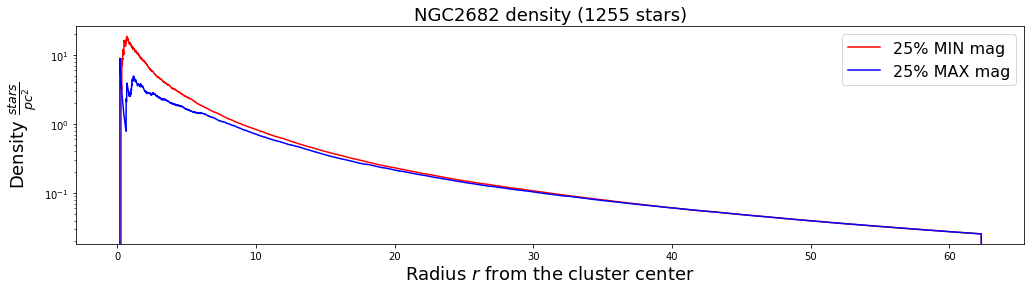

In [144]:
tab_name =  ["NGC2682","NGC2516","NGC2516_2","NGC6811"]
name = tab_name[0]
data = file_result[name]['data_cart']
percentage = 25

imin_mag, imax_mag = get_maxmin_index(data[:,5], percentage)

density_curve(data, name, percentage, smoothing = 0)

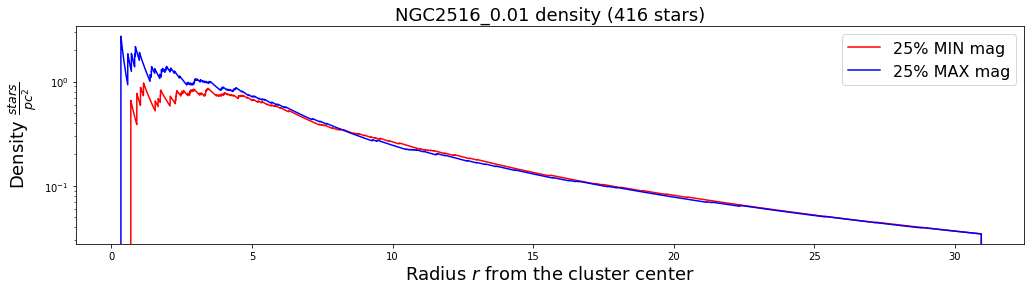

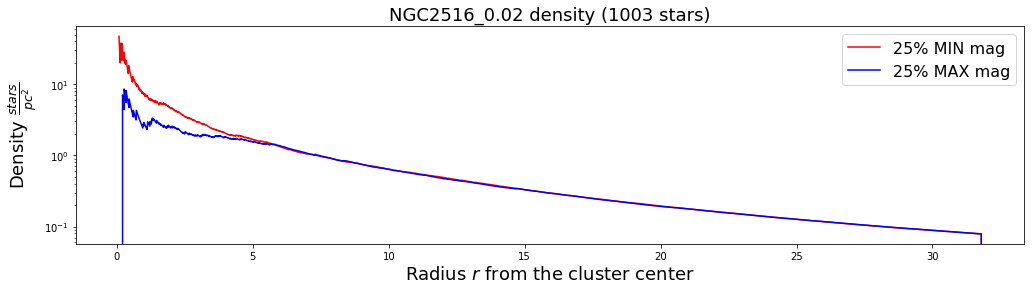

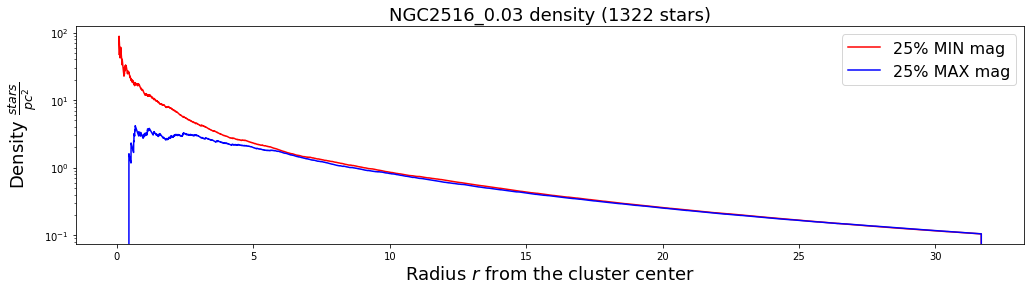

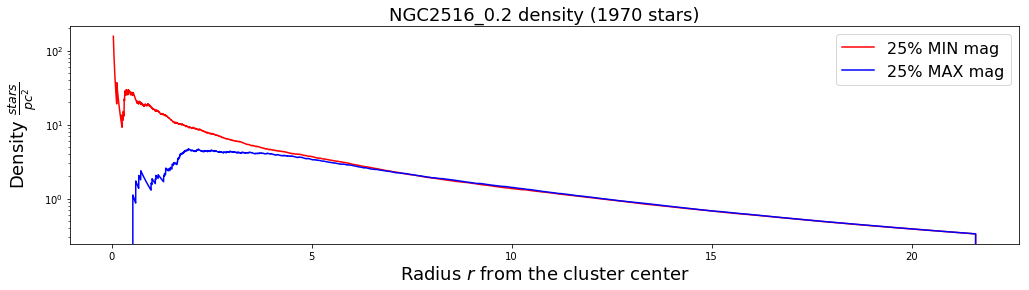

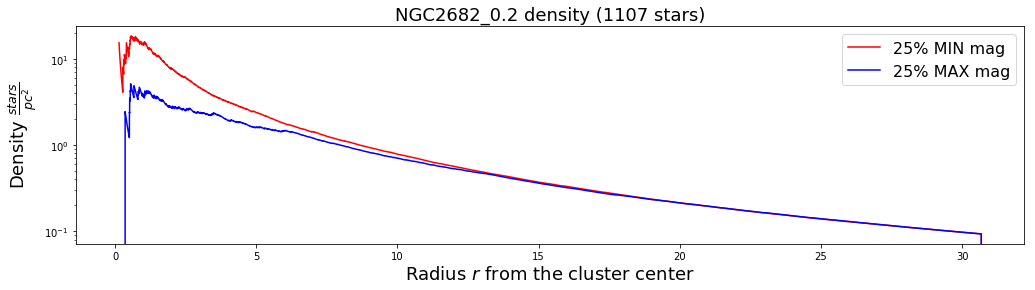

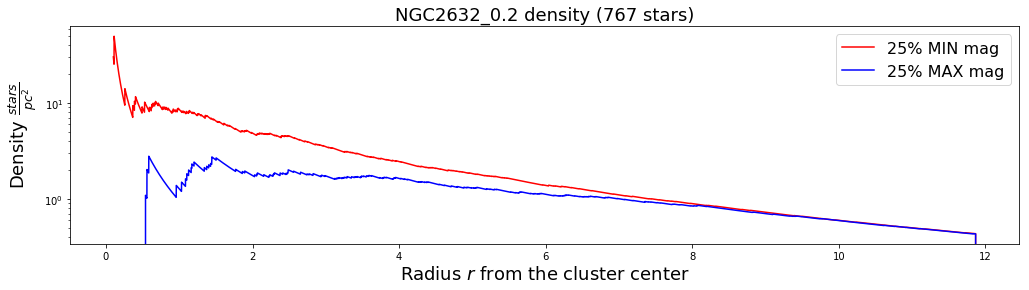

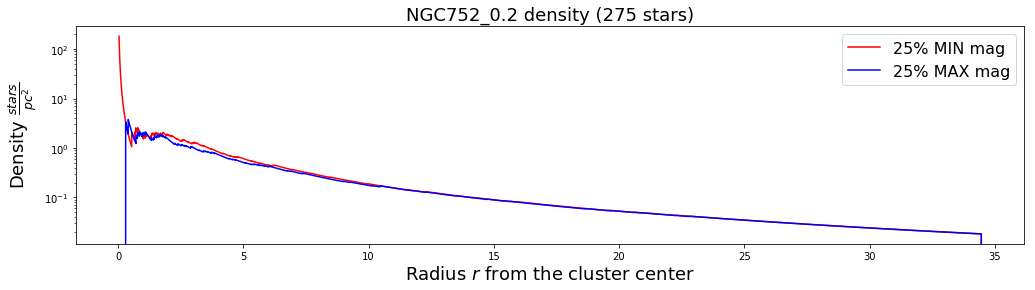

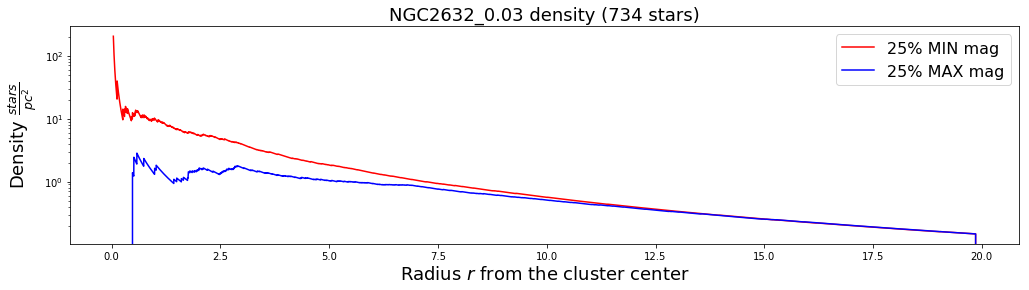

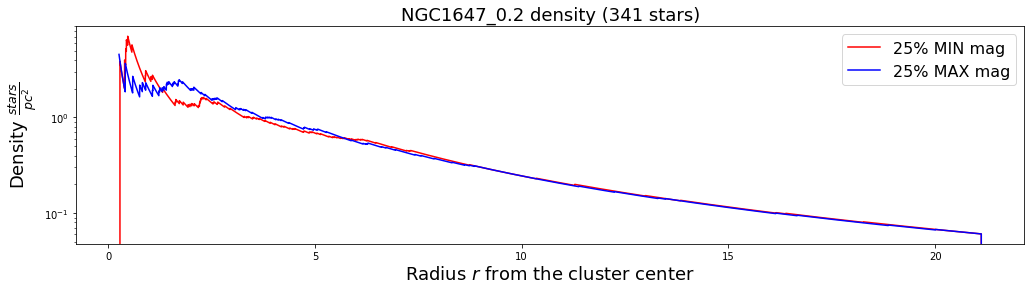

In [17]:
percentage = 25

for name in file_result :
    data = file_result[name]['data_cart']
    density_curve(data, name, percentage, smoothing = 0)

## ---------------------------------------------------------------------------------------------------------
## Cluster eigenvectors and eigenvalues

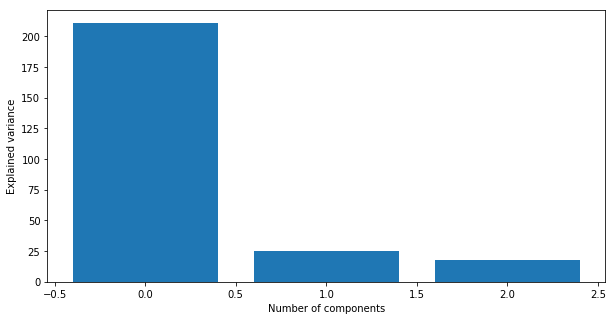

In [28]:
import pandas as pd
from sklearn.decomposition import PCA

name = "NGC2516_0.2"
data = file_result[name]['data_cart']
d1 = {'x': data[:,0], 'y': data[:,1], 'z': data[:,2]}
datapd = pd.DataFrame(data=d1)
Display = True

pcaR = PCA()
#composantes principales
pcaR.fit(datapd).transform(datapd)

if Display :
    plt.figure(figsize=(10,5))
    x=np.arange(pcaR.explained_variance_.size)
    plt.bar(x,pcaR.explained_variance_)
    #plt.axis((-1,20,0,175))
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance')
    plt.show()

In [29]:
print(len(data[:,0]))
color=['dodgerblue','orange','lime']
center = np.array([np.mean(data[:,0]),np.mean(data[:,1]),np.mean(data[:,2])])
lenght = 10

vecteur = np.zeros((3,3,2))
#pcaR.components_ est le vecteur propre unitaire, on le grossi dans le but de mieux le voir
#comp = lenght*pcaR.components_*pcaR.explained_variance_
comp = lenght*pcaR.components_
for i in range(3) :
    for j in range(3) :
        vecteur[i,j,:] = [center[j],center[j]+comp[i][j]]

1970


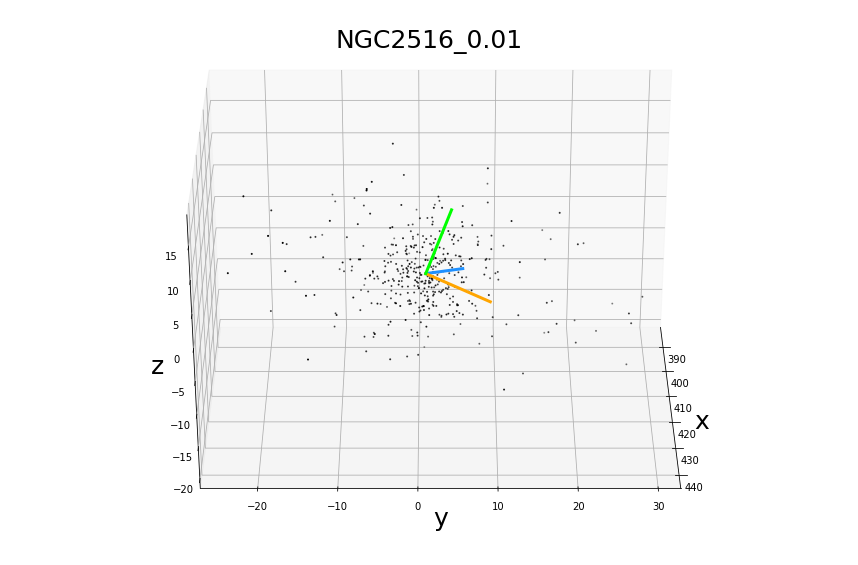

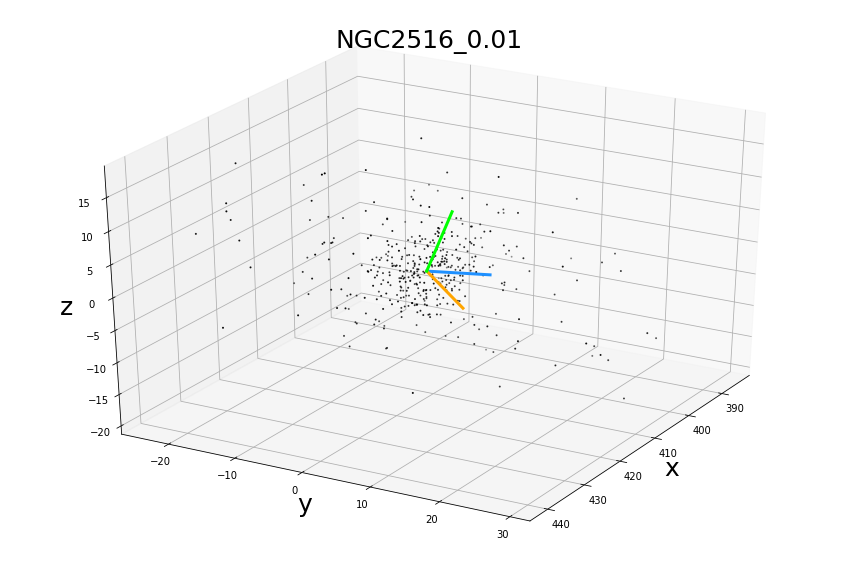

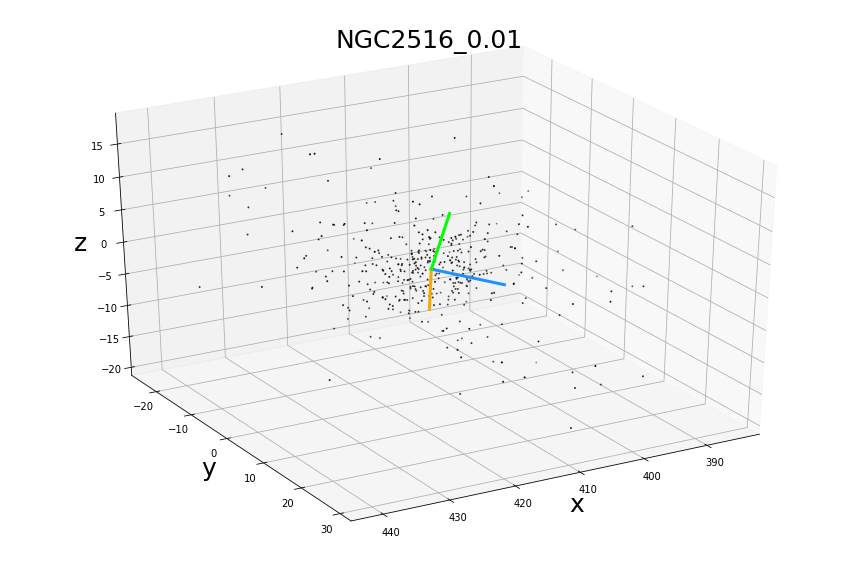

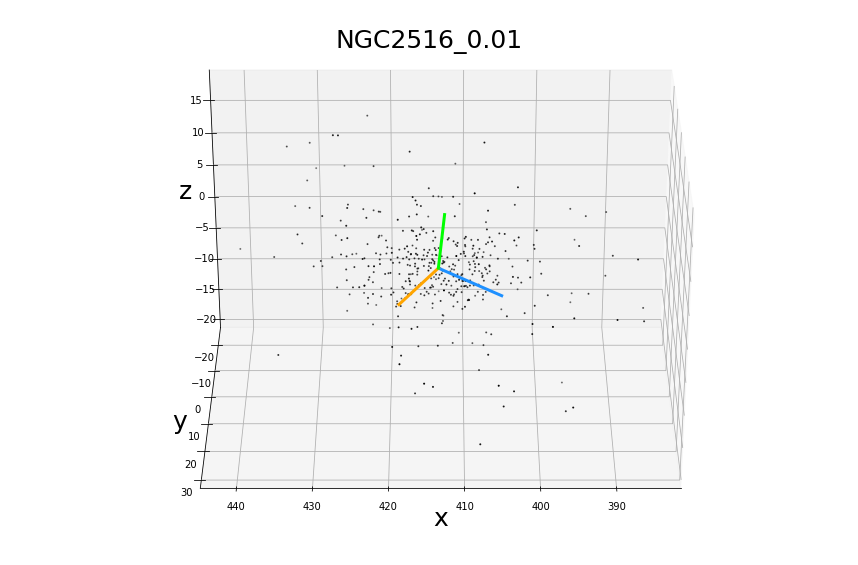

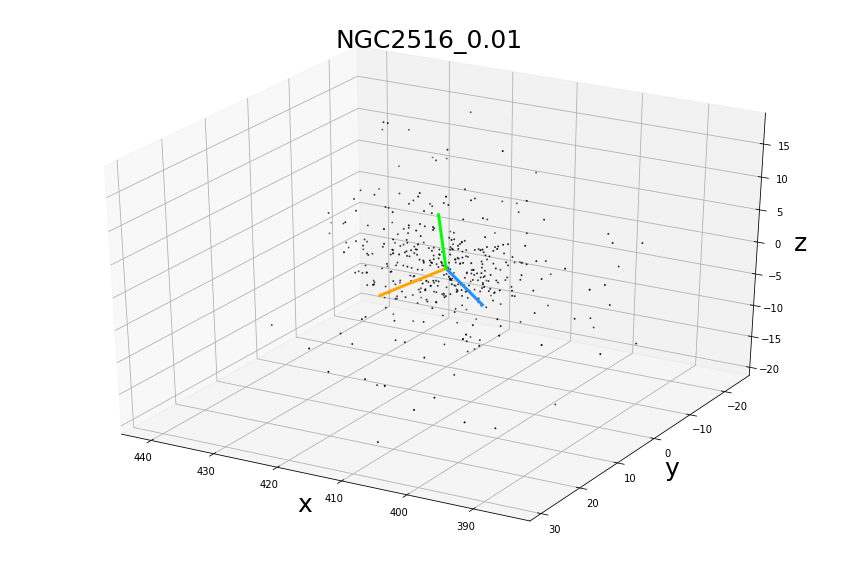

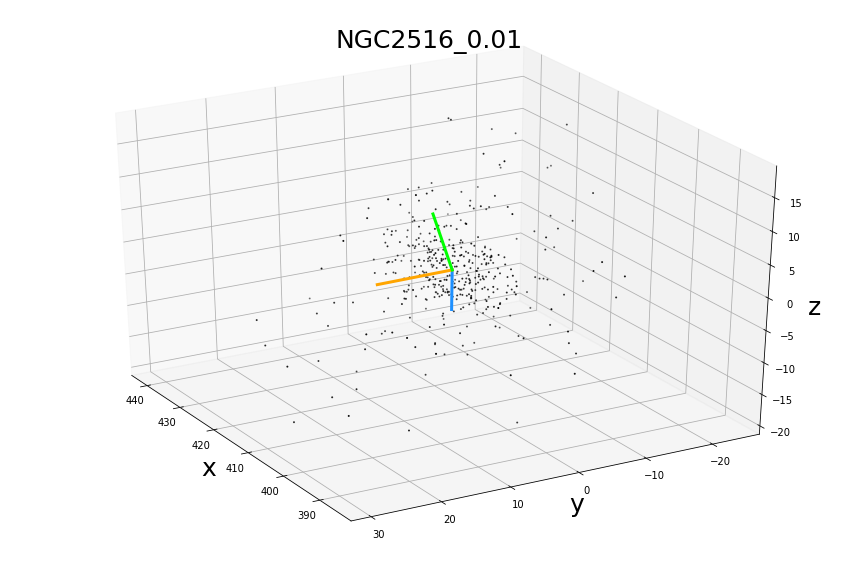

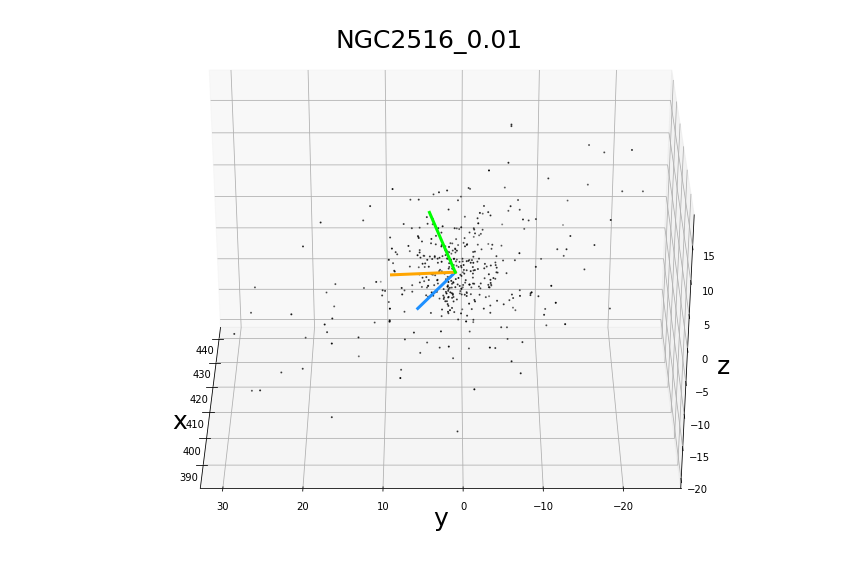

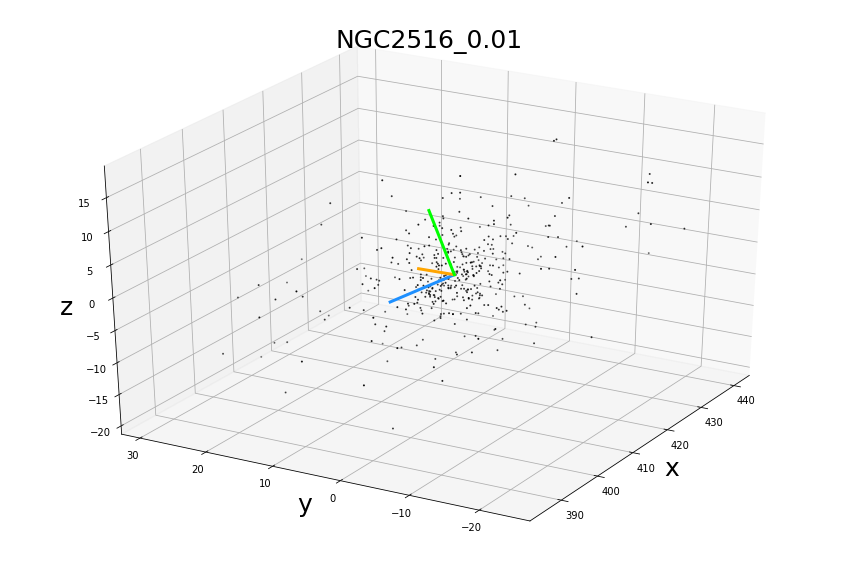

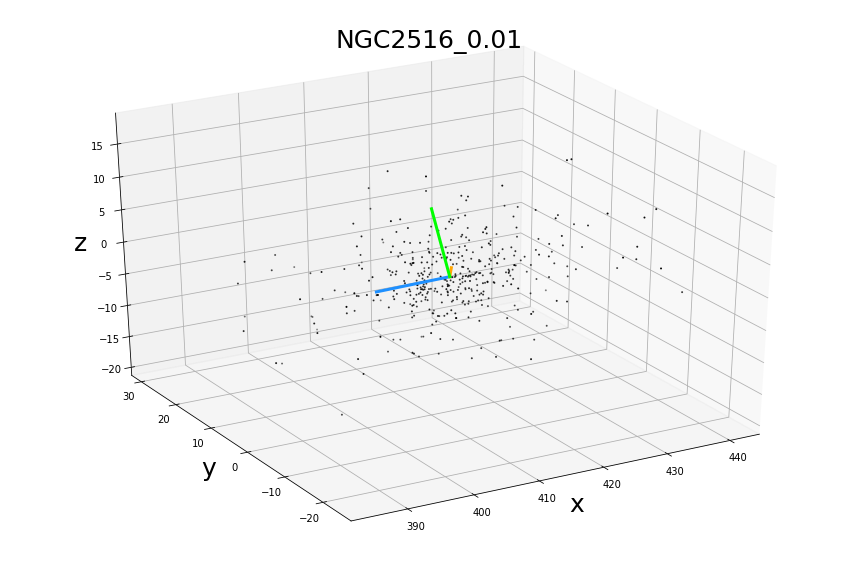

In [26]:
for angle in [0,30,60,90,120,150,180,210,240] :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], zdir='z', s=1, c='k', depthshade=True)
    for i in range(3) :
        ax.plot(vecteur[i,0,:],vecteur[i,1,:],vecteur[i,2,:], linewidth=3, c=color[i])

    ax.set_xlabel('x', fontsize=25); ax.set_ylabel('y', fontsize=25); ax.set_zlabel('z', fontsize=25)
    ax.set_title(name, fontsize=25)
    ax.view_init(azim=angle)
    plt.show()

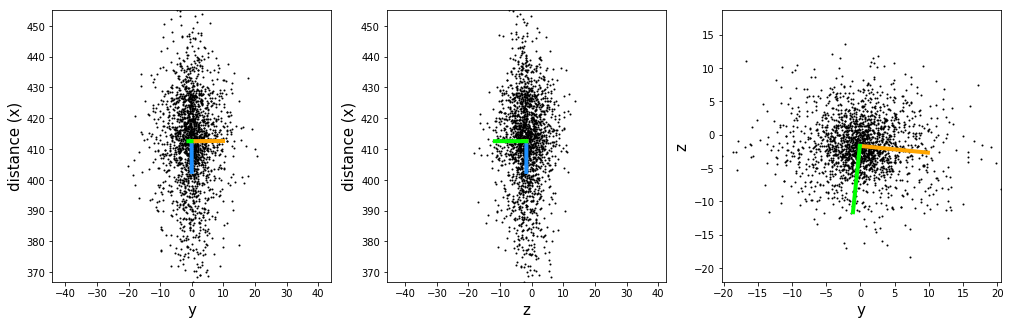

In [30]:
plt.figure(figsize=(17,5))

for i_x, i_y, j in zip((1,2,1),(0,0,2),(1,2,3)) :
    plt.subplot(1,3,j)
    plt.scatter(data[:,i_x],data[:,i_y],c='k',s=1)
    for i in range(3) :
        plt.plot(vecteur[i,i_x,:],vecteur[i,i_y,:], linewidth=4, c=color[i])
    plt.xlabel(gu.data_name_cart[i_x], fontsize=15)
    plt.ylabel(gu.data_name_cart[i_y], fontsize=15)
    
    xdim = max(data[:,i_x])-min(data[:,i_x])
    ydim = max(data[:,i_y])-min(data[:,i_y])
    if xdim > ydim :
        plt.xlim((min(data[:,i_x]),max(data[:,i_x])))
        plt.ylim((center[i_y]-0.5*xdim,center[i_y]+0.5*xdim))
    else:
        plt.ylim((min(data[:,i_y]),max(data[:,i_y])))
        plt.xlim((center[i_x]-0.5*ydim,center[i_x]+0.5*ydim))
    
plt.show()

## ------------------------------------------------------
## Dynamical state - Viriel


$ Virial_i =  2 T + V = \left( m_i v^2_i - \sum_{j}  \frac{G m_i  m_j}{r_{ij}} \right)$ for a star $i$ in the cluster

$G = 6,67408*10^{-11}m^3kg^{-1}s^{-2}$

$G = 1.32754*10^{12}km^3M_\odot^{-1}s^{-2}$

$\forall stars$ $i$ : $m_i = m = 1 M_\odot$

$E(Virial) = \frac{1}{N} \sum_{i} \left( m_i v^2_i - \sum_{j}  \frac{G m_i  m_j}{r_{ij}} \right)$

$E(Virial) = m \frac{1}{N} \sum_{i} v^2_i - m^2 \frac{1}{N} \sum_{i} \sum_{j}  \frac{G}{r_{ij}} $

Or we have centred velocity :
$\sigma_v^2 = \frac{1}{N} \sum_{i} (v^2_i - \bar v) = \frac{1}{N} \sum_{i} v^2_i$

$E(Virial) = m \dot{} \sigma_v^2 - \frac{m^2\dot{} G}{N} \sum_{i} \sum_{j}  \frac{1}{r_{ij}} $, and if $m = 1 M_\odot$

$E(Virial) = \sigma_v^2 - \frac{G}{N} \sum_{i} \sum_{j}  \frac{1}{r_{ij}} $

$1pc = \frac{648000}{\pi}AU$

with $1AU = 149 597 870.7 km$

$1pc = 30856775814913.67 km$

In [15]:
def virial(name) :
    
    data = file_result[name]['data_cart']
    nstars = len(data)

    x = data[:,0] - np.mean(data[:,0])
    y = data[:,1] - np.mean(data[:,1])
    z = data[:,2] - np.mean(data[:,2])

    Vy = data[:,3] - np.mean(data[:,3])
    Vz = data[:,4] - np.mean(data[:,4])

    Vy_std = np.std(Vy)
    Vz_std = np.std(Vz)
    #We assume that the velocity of the cluster is isotropique
    Vx_std = np.sqrt( (Vy_std**2 + Vz_std**2) / 2 )

    V_std = (Vx_std**2 + Vy_std**2 + Vz_std**2) / 3

    G = 1.32754 * 10**12
    sum_r = 0
    for i in range(nstars) :
        for j in range(nstars) :
            if i != j :
                r_pc = np.sqrt((x[i]-x[j])**2 + (y[i]-y[j])**2 + (z[i]-z[j])**2)
                r_km = r_pc*30856775814913.67
                sum_r += 1/r_km

    E_virial = V_std - (sum_r * G / nstars)

    return E_virial

In [27]:
print("   name_err       virial    std(x)/std(y)    nstars \n")
for name in file_result :
    data = file_result[name]['data_cart']
    E_virial = virial(name)
    string = ""
    if E_virial > 0 : string = " "
    print("%13s     %s%2.2f         %.2f          %d"%(name,string,E_virial,np.std(data[:,0])/np.std(data[:,1]),len(data)))

   name_err       virial    std(x)/std(y)    nstars 

 NGC2516_0.01     -0.79         1.17          416
 NGC2516_0.02     -2.57         1.56          1003
 NGC2516_0.03     -3.49         1.65          1322
  NGC2516_0.2     -5.46         2.91          1970
  NGC2682_0.2      2.44         7.28          1107
  NGC2632_0.2     -3.71         1.39          767
   NGC752_0.2      0.60         1.62          275
 NGC2632_0.03     -2.77         1.33          734
  NGC1647_0.2     -0.54         3.48          341


Virial in $[km]^2 \dot{} [M_\odot] \dot{} [s]^{-2}$

with $\mathbb{E}[Virial] = \sigma_v^2 - \frac{G}{N} \sum_{i} \sum_{j}  \frac{1}{r_{ij}} $ and $m = 1 M_\odot$

## ------------------------------------------------------
## Perturbations

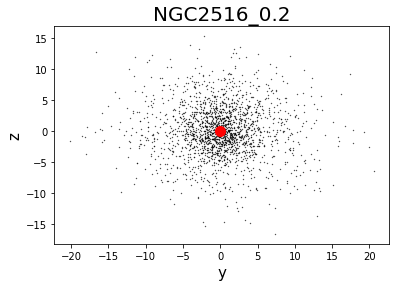

In [93]:
name = "NGC2516_0.2"
data = file_result[name]['data_cart']
nstars = len(data)

y = data[:,1] - np.mean(data[:,1])
z = data[:,2] - np.mean(data[:,2])

rho = np.sqrt(y**2 + z**2)
theta = np.arctan(z/y)

plt.scatter(y,z,s=0.1,c='k')
plt.scatter(0,0,s=100,c='r')
plt.title(name,fontsize=20);plt.xlabel('y',fontsize=15);plt.ylabel('z',fontsize=15)
plt.show()

#### Cartesian

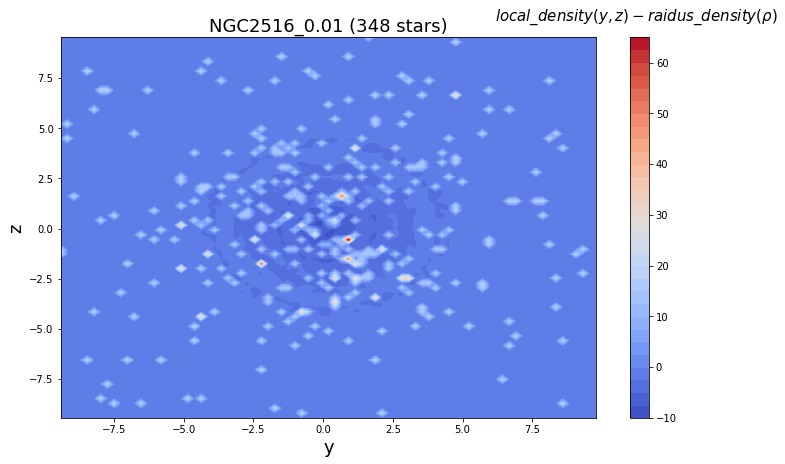

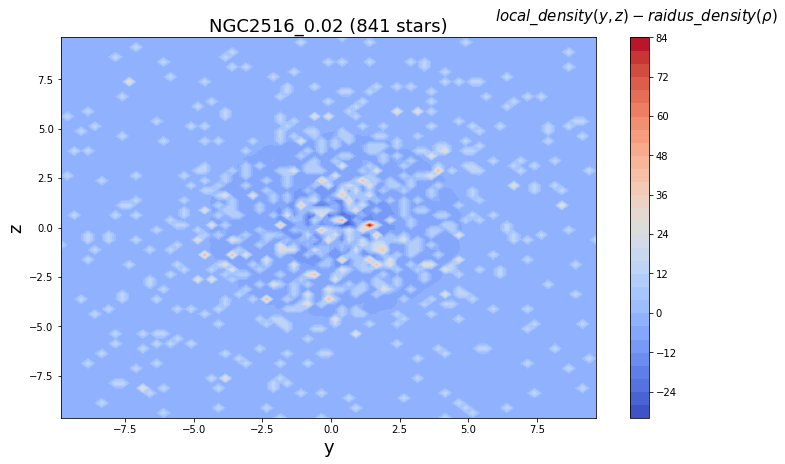

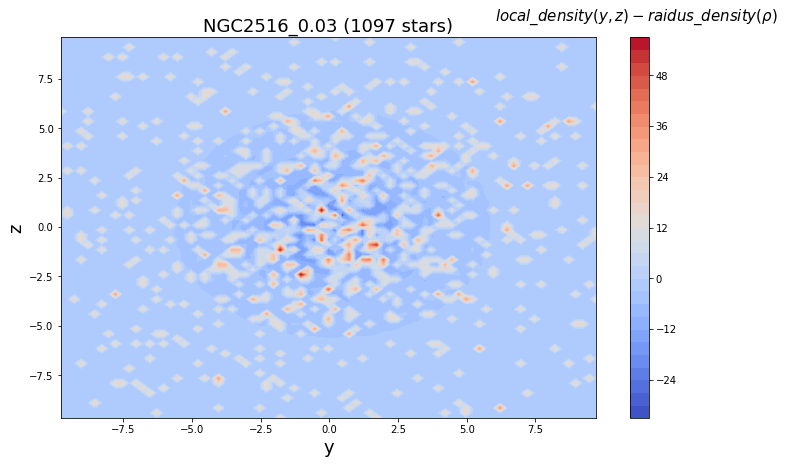

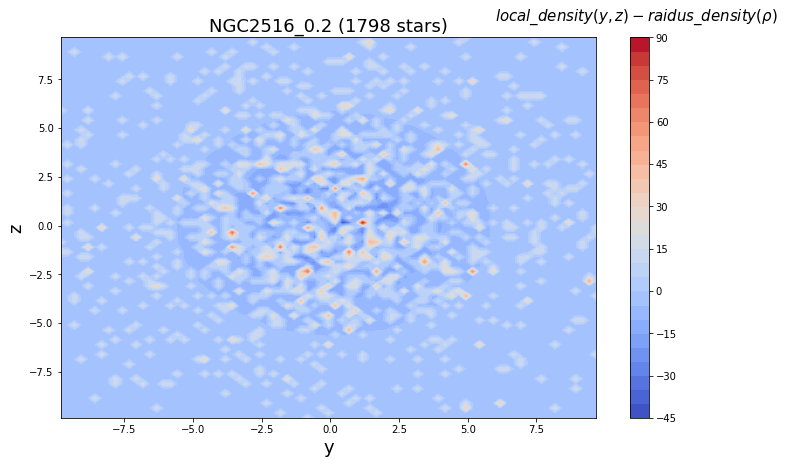

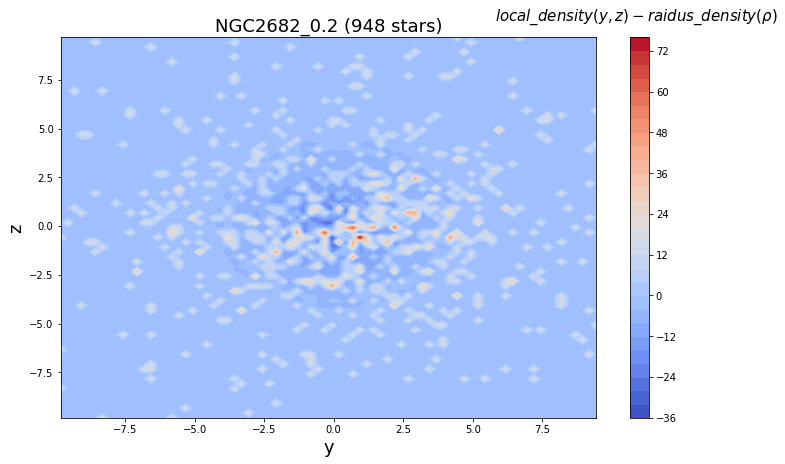

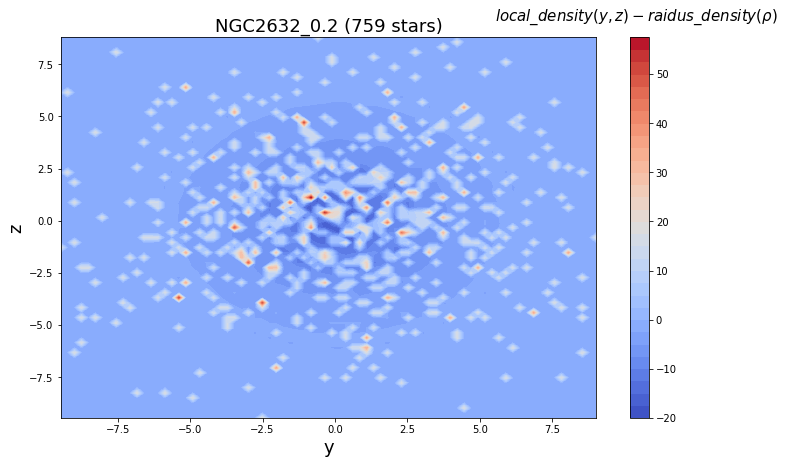

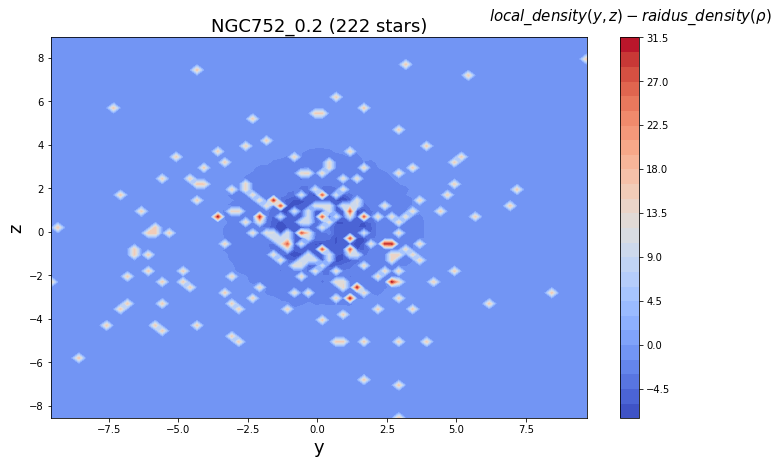

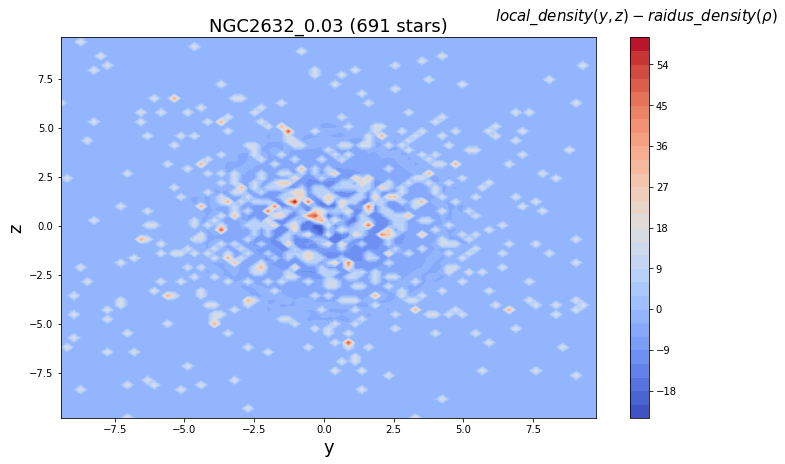

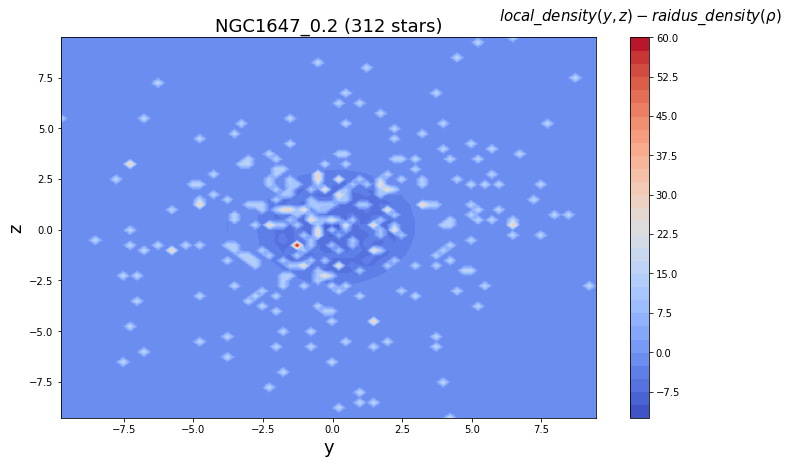

In [273]:
name = "NGC2516_0.2"
lissage = True
for name in file_result : 
    data = file_result[name]['data_cart']
    nstars = len(data)

    y = data[:,1] - np.mean(data[:,1])
    z = data[:,2] - np.mean(data[:,2])
    
    ilab = np.where((y>-10) & (y<10) & (z>-10) & (z<10))[0]
    y = y[ilab]
    z = z[ilab]
    
    rho = np.sqrt(y**2 + z**2)
    
    dz = dy = round((max(y) - min(y))/80, 2)
    #dz = dy = 0.8
    dr = np.sqrt(dy**2+dz**2)
    Y = np.arange(min(y), max(y), dy)
    Z = np.arange(min(z), max(z), dz)
    
    YY, ZZ = np.meshgrid(Y, Z)

    d = np.zeros((len(Z),len(Y)))
    for i in range(d.shape[0]) :
        for j in range(d.shape[1]) :
            local_density = len(np.where((y>Y[j]-0.5*dy) & (y<Y[j]+0.5*dy) & (z>Z[i]-0.5*dz) & (z<Z[i]+0.5*dz))[0])/(dy*dz)

            r = np.sqrt(Y[j]**2 + Z[i]**2)
            nb_r = len(np.where((rho < r + 0.5*dr) & (rho > max(r-0.5*dr,0)))[0])
            surface = volume(r + 0.5*dr) - volume( max(r - 0.5*dr, 0) )
            global_density = nb_r / surface

            d[i,j] = local_density - global_density

    if lissage == False : 
        plt.figure(figsize=(12,8))
        plt.imshow(d, extent=[min(y), max(y),min(z), max(z)], cmap='coolwarm')
        plt.title("%s (%d stars)"%(name,len(y)), fontsize=18); plt.xlabel('y', fontsize=18); plt.ylabel('z', fontsize=18)
        clb = plt.colorbar()
        clb.set_label(r'$local\_density(y,z) - raidus\_density(\rho)$', labelpad=-40, y=1.08, rotation=0, fontsize=15)
        #plt.scatter(y,z,s=0.8,c='k')
        #plt.scatter(0,0,s=100,c='r')
        #if name == "NGC2516_0.03" : plt.savefig('density.png')
    else :
        z = d[:-1, :-1]
        levels = MaxNLocator(nbins=32).tick_values(z.min(), z.max())
        cmap = plt.get_cmap('coolwarm')
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
        fig, ax1 = plt.subplots(figsize=(12,7))
        cf = ax1.contourf(YY[:-1, :-1] + dy/2., ZZ[:-1, :-1] + dz/2., z, levels=levels, cmap=cmap)
        clb = fig.colorbar(cf, ax=ax1)
        clb.set_label(r'$local\_density(y,z) - raidus\_density(\rho)$', labelpad=-40, y=1.08, rotation=0, fontsize=15)
        ax1.set_title("%s (%d stars)"%(name,len(y)), fontsize=18)
        ax1.set_xlabel('y', fontsize=18); ax1.set_ylabel('z', fontsize=18)
    
    plt.show()

#### Polaire

(10, 71)
(10, 71)
(71, 10)


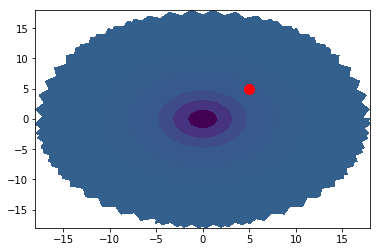

In [215]:
name = "NGC2516_0.2"
data = file_result[name]['data_cart']
nstars = len(data)

y = data[:,1] - np.mean(data[:,1])
z = data[:,2] - np.mean(data[:,2])
rho = np.sqrt(y**2 + z**2)
theta = np.arctan(z/y)

dr = 2
dtheta = 5

R = np.arange(0, max(rho), dr)
T = np.arange(0, 360, dtheta)

d = np.zeros((len(T)-1,len(R)-1))
for j in range(d.shape[1]) :
    global_density = len(np.where((rho >= R[j]) & (rho < R[j+1]))[0]) / (volume(R[j+1]) - volume(R[j]))
    for i in range(d.shape[0]) :
        nb = len(np.where((rho >= R[j]) & (rho < R[j+1]) & (theta >= T[i]*np.pi/180) & (theta < T[i+1]*np.pi/180))[0])
        surface = (T[i+1]-T[i])*np.pi/180/2 * (R[j+1]**2 - R[j]**2)
        local_density = nb / surface

        d[i,j] = local_density - global_density

TT, RR = np.meshgrid(T[:-1], R[:-1])
print(RR.shape)
print(TT.shape)
print(d.shape)

phi_grid, r_grid = np.meshgrid(T[:-1], R[:-1])
x, y = r_grid*np.cos(phi_grid), r_grid*np.sin(phi_grid)
plt.pcolormesh(x, y, d.T)
plt.scatter(5,5,s=100,c='r')
plt.show()

#fig, ax = plt.subplots(subplot_kw=dict(projection='polar'),figsize=(12, 9))
#im = ax.contourf(TT, RR, d.T)
#fig.colorbar(im, ax=ax)
#plt.show()

In [191]:
print(azimuths.shape)
print(zeniths.shape)
print(r.shape)
print(theta.shape)
print(values.shape)

(20,)
(7,)
(20, 7)
(20, 7)
(20, 7)


## ------------------------------------------------------
## Deconvolution

In [28]:
from scipy import signal
original = [0, 1, 0, 0, 1, 1, 0, 0]
impulse_response = [2, 1]
recorded = signal.convolve(impulse_response, original)
print(recorded)
recovered, remainder = signal.deconvolve(recorded, impulse_response)
print(recovered)

[0 2 1 0 2 3 1 0 0]
[0. 1. 0. 0. 1. 1. 0. 0.]


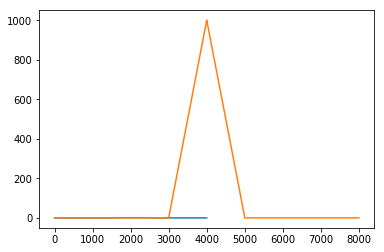

In [36]:
a = np.zeros(4000)
#x = np.range()
a[1500:2500] = 1
plt.plot(a)
plt.plot(np.convolve(a,a))
plt.show()

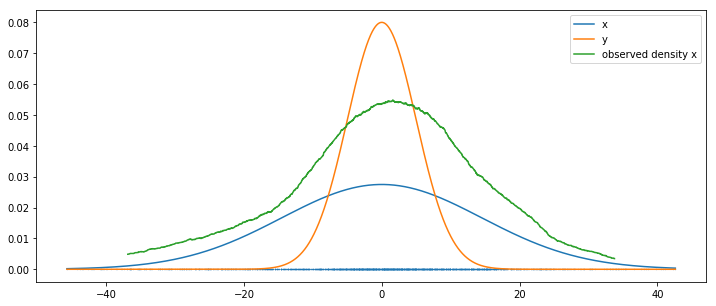

In [79]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np

name = "NGC2516_0.2"
data = file_result[name]['data_cart']

nb_point = 5000
x_data = np.sort(data[:,0]-np.mean(data[:,0]))
x = np.linspace(min(x_data), max(x_data), nb_point)

pcent = 0.1
p = int(nb_point*pcent)

density = []
for i in range(p,nb_point-p) :
    density.append( len(np.where((x_data < x[i+p]) & (x_data > x[i-p]))[0]) )
density = 100*np.array(density)/sum(density)
    
plt.figure(figsize=(12,5))
plt.plot(x,scipy.stats.norm.pdf(x,0,np.std(data[:,0])),label='x')
plt.plot(x,scipy.stats.norm.pdf(x,0,np.std(data[:,1])),label='y')
plt.plot(x[p:-p],density,label='observed density x')
plt.scatter(x_data,np.zeros(len(x_data)),s=0.1)
plt.legend(loc=0)
plt.show()

5500 0.06746850676817365
500 0.06744077226657318


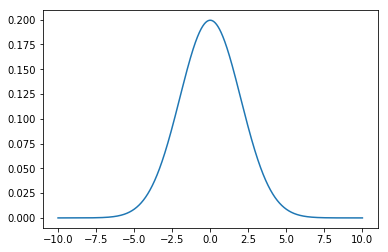

10999 0.043223600996197625


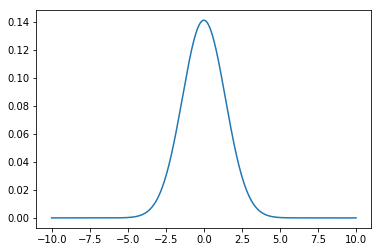

In [128]:
x = np.linspace(-10, 10, 5500)
x2 = np.linspace(-10, 10, 500)
x3 = np.linspace(-10, 10, 10999)

gx = scipy.stats.norm.pdf(x,0,2)
gy = scipy.stats.norm.pdf(x2,0,2)


gdiff = scipy.stats.norm.pdf(x,0,sigma_diff)

g, remainder = signal.deconvolve(data[:,0], gdiff)


plt.plot(x,gx)
#plt.plot(x2,gy)
print(len(gx),np.std(gx))
print(len(gy),np.std(gy))
plt.show()
conv = np.convolve(gx,gx) / sum(gx)
print(len(conv),np.std(conv))
#plt.plot(x,gx)
plt.plot(x3,conv)
plt.show()

## ------------------------------------------------------
## Plotting data to see the cluster

In [10]:
#ilabel = ilabel_[0]
size = 0.8
index = 0

for index in range(len(tab_source)) :

    center = np.mean(tab_source[index].dfcart[tab_ilabel[index],0])

    plt.figure(figsize=(19,9))                
    for i_x, i_y, i in zip((1,2),(0,0),(1,2)) :
        plt.subplot(1,2,i)
        if i <= 2 : plt.title(tab_source[index].name, fontsize=20)
        plt.scatter(tab_source[index].dfcart[:,i_x],tab_source[index].dfcart[:,i_y],s=size,c='k')
        #plt.scatter(tab_source[index].dfcart[tab_ilabel[index],i_x],tab_source[index].dfcart[tab_ilabel[index],i_y],s=size*300,c='r')
        plt.xlabel(gu.data_name_cart[i_x], fontsize=25)
        plt.ylabel(gu.data_name_cart[i_y], fontsize=25)
        plt.ylim(center-60,center+60)
        plt.xlim(-60,60)
    plt.show()

NameError: name 'tab_source' is not defined